## Hierarchical Clustering

Basic example of Hierarchical Clustering implementation

### About the Data

The healthcare_CyberAttacks dataset is an aggregated table that contains number of attacks and total affected people by state and it was derived from the Breach Report Dataset that contains information about resolved cyber attack cases reported to HIPPA from 10/2009 to 01/2023

Variables:

* State
* Individuals Affected
* attacks

## 1. Importing Libraries

In [20]:
# data handling and formating
import pandas as pd
import numpy as np

# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# importing KMeans method
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# scaling data
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# supressing warnings
import warnings
warnings.simplefilter('ignore')

## 2. Data Load & Overview

In [21]:
# importing data
data = pd.read_csv('../Data/healthcare_CyberAttacks.csv')

In [22]:
# creating a copy to avoid permanent changes
df = data.copy()

In [23]:
# looking at the size of the dataset
print(f' *There are {df.shape[0]} observations')
print(f' *There are {df.shape[1]} variables including a dependant variable')

 *There are 52 observations
 *There are 3 variables including a dependant variable


In [24]:
# looking at the data
df.head()

,State,Individuals Affected,attacks
0,AK,500000.0,19
1,AL,8702.0,51
2,AR,8871.0,60
3,AZ,1337.0,100
4,CA,2646.0,461


* data contains total number of affected individuals by state and total number of attacks by state
* data is from 10/2009 to 01/2023

In [25]:
# looking for missing values
df.isnull().sum()

State                   0
Individuals Affected    0
attacks                 0
dtype: int64

* There are no missing values

In [26]:
df.dtypes

State                    object
Individuals Affected    float64
attacks                   int64
dtype: object

## 3. Data Preprocessing

* Clustering can not handle categorical/object types therefore we will only use Individuals `Affected` and `attacks`
* Clustering means deals with distances therefore we will have to scale our data for better results

In [27]:
# we will create a dataframe with the numerical variables only
training = df[['Individuals Affected', 'attacks']]

In [28]:
# defining scaler
scaler = StandardScaler()
# creating new dataset with scaled values
df_scaled = pd.DataFrame(scaler.fit_transform(training), columns=training.columns)

## 4. Model

* Select the best number of clusters, distance metric and linkage method
* Build model
* visualize clusters
* Analyze clusters

## 4.1 Selecting the best number of clusters, distance metric and linkage method

we will use the cophenet correlation value and a dendogram to acomplish this

* we will experiment with some of the distance metrics and linkage methods to find the best cophenet value

In [29]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis"]

# list of linkage methods
linkage_methods = ["single","complete", "average", "weighted"]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )


Cophenetic correlation for Euclidean distance and single linkage is 0.9117467469809415.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8673853407069656.
Cophenetic correlation for Euclidean distance and average linkage is 0.8827720638122053.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8595381046704752.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9221027189057523.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8695587121337761.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9293965770447936.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8591908386349629.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9156985215933238.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.8507499370996529.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8837951112335292.
Cophenetic co

the distance metric and linkage combination with the highest cophenetic correlation values is `(Chebyshev,Average)`

Now, we will create a dendogram of the scaled data to visualize the clusters

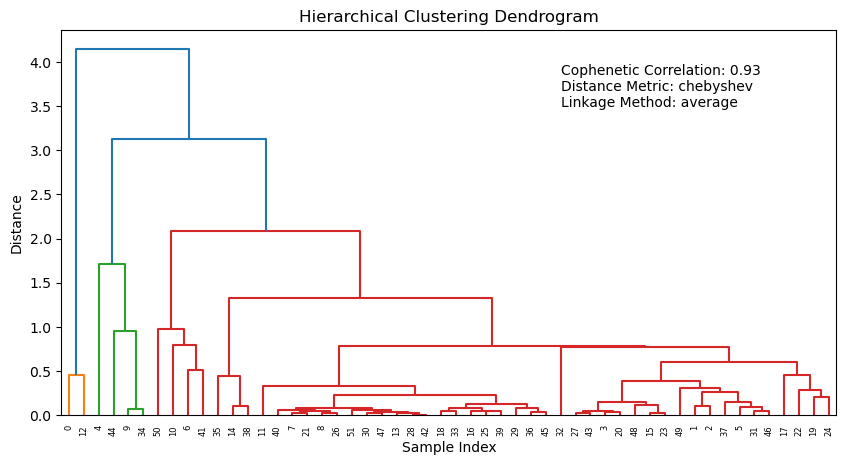

In [30]:
Z = linkage(df_scaled, metric='chebyshev', method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z)
coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
plt.annotate(
        '''
        Cophenetic Correlation: {:.2f}
        Distance Metric: chebyshev
        Linkage Method: average'''.format(coph_corr),
        (0.60, 0.80),
        xycoords="axes fraction",
    )
plt.show()

From the visually inspecting the dendogram we will select the number of clusters as 3

## 4.2 Building Model

Building model and creating clusters

In [31]:
# using the parameters found before we define the model
model = AgglomerativeClustering(n_clusters=3, linkage='average', metric='chebyshev')

# fit the data
model.fit(df_scaled)

# adding the clusters to our original and scaled data
df_scaled["cluster"] = model.labels_
df["cluster"] = model.labels_

## 4.3 Visualize Clusters

[Text(0.5, 1.0, 'K-Means Clustering')]

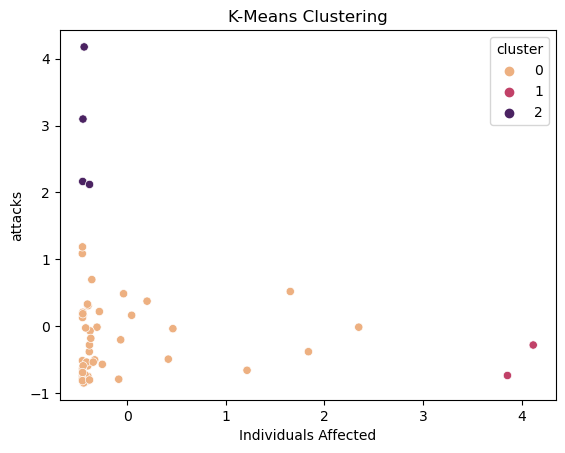

In [32]:
sns.scatterplot(data=df_scaled, x="Individuals Affected", y="attacks", hue=df_scaled['cluster'], palette='flare').set(title='K-Means Clustering')

* `Cluster 2`: contains the states that are frequently targeted but also have really low affected individuals
    - Highly targeted, High Security
* `Cluster 0`: contains the states that are not targeted too often and have relatively low affected individuals
    - Somewhat targeted, Medium security
* `Cluster 1`: contains the states that are not highly targeted but have the highest numbers of affected individuals
    - Rarely targeted, Low Security

## 4.4 Analyze Clusters

In [33]:
# adding clusters to original data
df['cluster'] = df_scaled['cluster']

In [34]:
# looping through clusters and returning its state members and summary statistics
for cluster in df['cluster'].unique():
    print('''\nCluster {} Details:\n '''.format(cluster))
    cluster_data = df[df['cluster']==cluster]
    print(f'States in this cluster: {list(cluster_data.State)}\n')
    display(cluster_data[['Individuals Affected','attacks']].describe().T)
    print('='*150)


Cluster 1 Details:
 
States in this cluster: ['AK', 'IA']



,count,mean,std,min,25%,50%,75%,max
Individuals Affected,2.0,515149.5,21424.628363,500000.0,507574.75,515149.5,522724.25,530299.0
attacks,2.0,39.5,28.991378,19.0,29.25,39.5,49.75,60.0



Cluster 0 Details:
 
States in this cluster: ['AL', 'AR', 'AZ', 'CO', 'CT', 'DC', 'DE', 'GA', 'HI', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']



,count,mean,std,min,25%,50%,75%,max
Individuals Affected,46.0,37456.369565,74486.245638,500.0,1360.75,7125.0,23128.0,325278.0
attacks,46.0,64.608696,47.878772,9.0,23.75,51.0,100.0,192.0



Cluster 2 Details:
 
States in this cluster: ['CA', 'FL', 'NY', 'TX']



,count,mean,std,min,25%,50%,75%,max
Individuals Affected,4.0,3453.00,3758.740303,941.0,1169.0,1945.5,4229.50,8980.0
attacks,4.0,345.25,87.183236,276.0,279.0,322.0,388.25,461.0
